# Titanic survival classification
by Stefanie Müller

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier #?
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import f1_score
from ScoreAggregatorHeatmap import ScoreAggregator

In [2]:
%%html
<style>
table {float:left}
</style>

# 1. Load Data and prepare
Data Source: https://www.kaggle.com/c/titanic/data

Only train.csv will be used because the test.csv has no labels for "Survived".

| Variable | Definition | Key |
| :- | :- | :- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
| sex | Sex	 |  | 
| Age | Age in years	 |  | 
| sibsp | # of siblings / spouses aboard the Titanic	
| parch | # of parents / children aboard the Titanic	
| ticket | Ticket number	
| fare | Passenger fare	
| cabin | Cabin number	
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |




In [3]:
df = pd.read_csv("train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Describe Data

In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### a. Checking for NaN
There are lots of missing data in the variable "Cabin". "Age" also consists of several NaNs while "Embarked" only has 2 missing values. The missings have to be handeled before using ML-Classificationalgorithms on the data.

In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### b. Checking data types
Before preparing the data we need to know which types they are.

In [6]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Save Column_types
Since numerical and categorical data have to be preprocessed in a different way, we save the according variables here.

In [7]:
numerical_cols = ["Pclass", "SibSp", "Parch", "Age", "Fare"]
categorical_cols = ["Sex", "Embarked"]

### c. Dropping not needed columns
1. The PassengerId serves as an index. Thus there is no further information included and it can be dropped.
2. For the name there might even be further information because it contains the titles of the passengers. People with a title might have been saved prior to others. This is something which has to be considered during the Feature Engineering process when using real data. For the simplicity of this analysis, the Name will be excluded.
3. Ticket seems to not help for prediction purposes because there is no further information about the ticket naming. It might not conclude any helpfull information at all.
4. Cabin has lots of missing values which do not seem to say the passenger had no cabin. Information from the titanic wiki provides that every passenger had a place to sleep. Thus everyone should have had a cabin. This variable will be excluded due to missing value for the prognosis.

In [8]:
df = df.drop(["PassengerId","Name", "Ticket", "Cabin"], axis=1)

In [9]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


### d. Plotting variables distributions
Most people traveled on 3rd Pclass while there were almost double as many male than female passengers. The age is mostly distributed around 15 to 35. Most people traveled alone. The majority of ticket costs (Fare) was pretty low compared to the expensive ones. In Southhampton most people embarked.

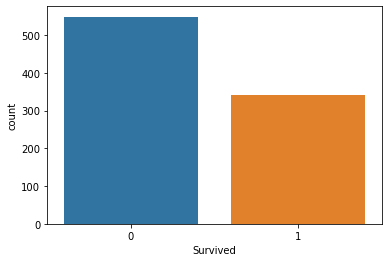

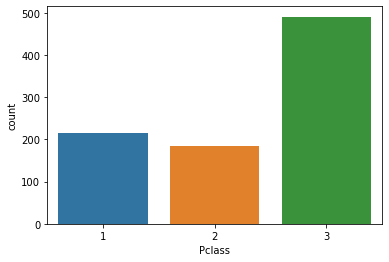

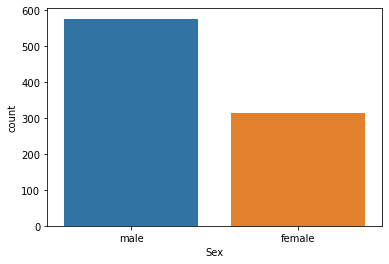

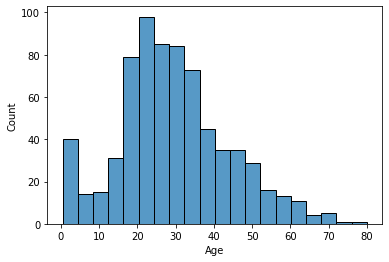

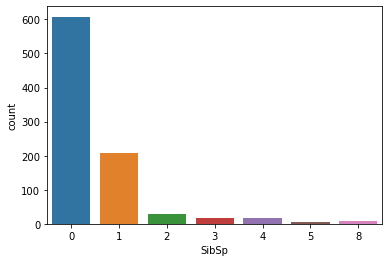

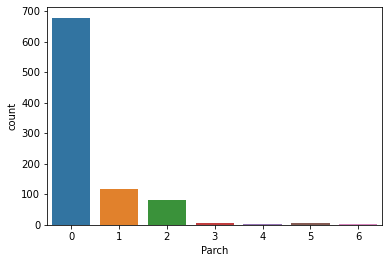

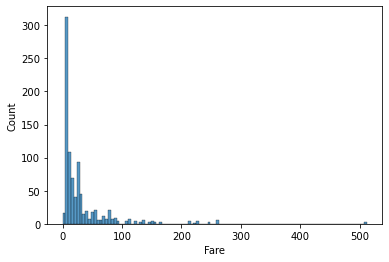

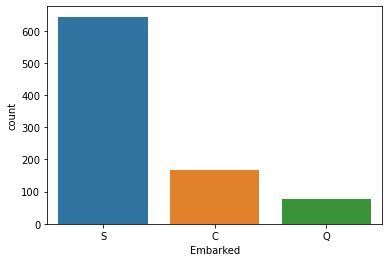

In [10]:
for col in df.columns:    
    if df[col].dtypes == 'float64': 
        sns.histplot(data=df, x=col)
        plt.show()
        
    elif df[col].dtypes == 'int64' or col in ['Sex', 'Embarked']:
        sns.countplot(data=df, x=col)
        plt.show()

### Plotting survival distributions
The plots look like that there are several correlations between the variables and the survival rate. Overall about 60% did not survive. The ratio for 1st and 2nd Pclass is way better than for the 3rd class, while it is also much better for female passengers than for male. People who did not travel alone had a better chance of survival than those who did. Higher fare seems to provide also a greater chance of survival which fits with the distribution of Pclass. People who embarked in Southhampton had a worse ratio than those who embarked on Queenstown or Cherbourg.

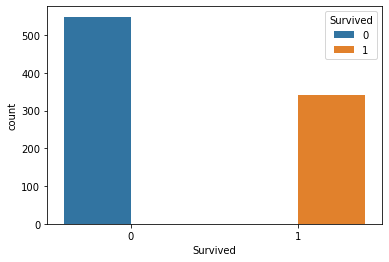

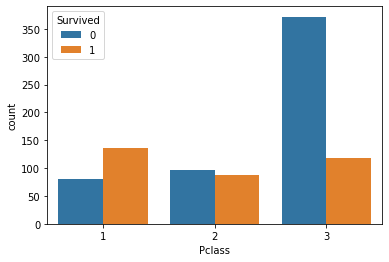

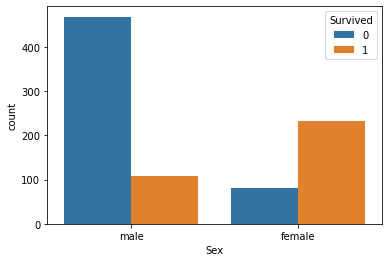

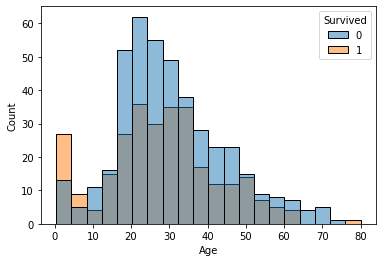

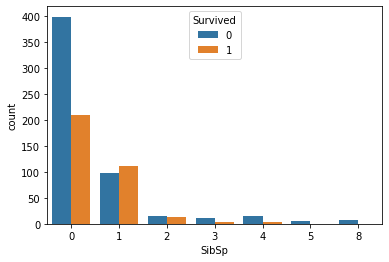

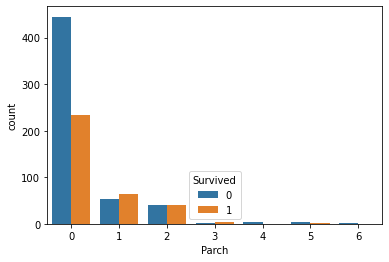

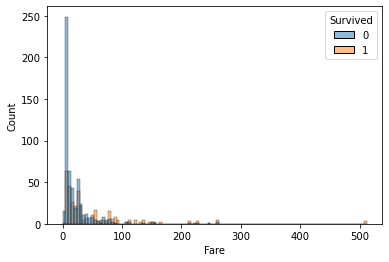

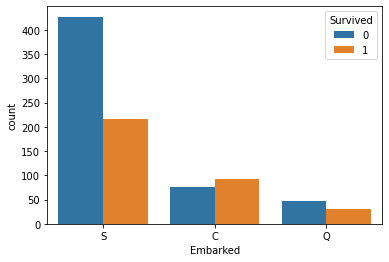

In [11]:
for col in df.columns:
    if df[col].dtypes == 'float64': 
        sns.histplot(data=df, x=col, hue='Survived')
        plt.show()
        
    elif df[col].dtypes == 'int64' or col in ['Sex', 'Embarked']:
        sns.countplot(data=df, x=col, hue='Survived')
        plt.show()

### Correlation Matrix
To be precise we would need to calculate the correlations for metric and categorical data in a different way. For the sake of a fast and easy overview, the pearson correlation coefficient calculations are used here. <br>
The correlation matrix indeed shows some correlations. The Pclass and Fare of course correlate negative as expected. Those variables also correlate with the chance of survival. People in lower classes, who payed a lower Fare survived less often.

<AxesSubplot:>

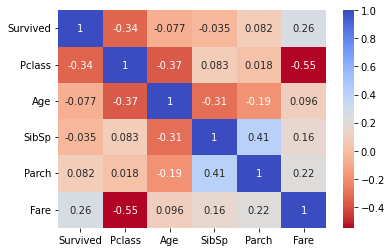

In [12]:
corr_matrix = pd.DataFrame.corr(df)
color_palette = sns.color_palette("coolwarm_r", as_cmap=True)
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, annot=True, cmap = color_palette)

### e. Specifieing X and y

In [13]:
X = df.drop("Survived", axis=1)

In [14]:
y = df["Survived"]

# 2. Test-Train-Split and scaling

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

### Preprocessing the columns
Two types are specified above as numerical_cols and categorical_cols.

1. numeric data will be imputed with the median and then scaled via StandardScaler
2. categorical data will be imputet with the most_frequent values and then encoded via OrdinalEncoder

In [16]:
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OrdinalEncoder())])
        #('onehot', OrdinalEncoder(unknown_value=np.nan, handle_unknown='use_encoded_value'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

prepped_X_train = preprocessor.fit_transform(X_train)
prepped_X_test = preprocessor.transform(X_test)

In [17]:
prepped_X_train.shape

(712, 7)

### Splitting the data again to get a validation set
This will only be used to inspect the principal components.

In [18]:
prepped_X_train_train, prepped_X_train_val, y_train_train, y_train_val = train_test_split(prepped_X_train,
                                                                                          y_train,
                                                                                          stratify=y_train, random_state=42)

# 3. PCA test and comparison with random forest
Looks like there would be a great loss in the score when using PCA. Normally full PCA should be the same score compared to no PCA. That is isn't the case here seems to be rooted in the imputing values for the variable "age". When deleting "Age" instead of imputing and performing the PCA, the scores for no PCA and full PCA are identical: <br>
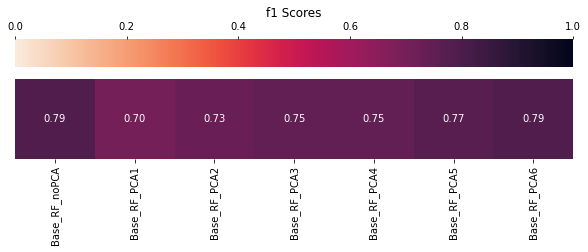

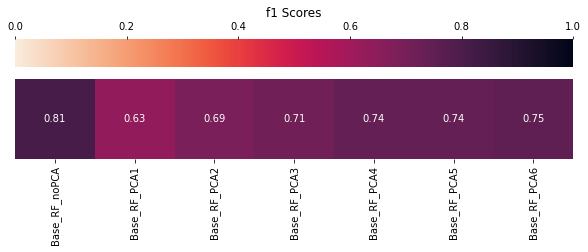

In [19]:
scores_rf = ScoreAggregator(y_train_val)

def rf_pca_test():
    #Random Forest:
    rf = RandomForestClassifier()
    rf.fit(prepped_X_train_train, y_train_train)

    scores_rf.add_score('Base_RF_noPCA', rf.predict(prepped_X_train_val))

    for i in range(1,7):
        #PCA:
        pca = PCA(n_components=i)
        prepped_X_train_train_PCA = pca.fit_transform(prepped_X_train_train)
        prepped_X_train_val_PCA = pca.transform(prepped_X_train_val)

        rf_PCA = RandomForestClassifier()
        rf_PCA.fit(prepped_X_train_train_PCA, y_train_train)

        scores_rf.add_score(f'Base_RF_PCA{i}', rf_PCA.predict(prepped_X_train_val_PCA))

rf_pca_test()
plotrf = scores_rf.show_score_table(show=True)

Since we have just a low amount of data plus loosing score due to PCA, a PCA makes no sense here. For large datasets a PCA with less n_components could help reducing computation time while still providing a decent score.

# 4. Gridsearch for each Classifier
GridSearch helps finding optimal hyperparameters for a Classifier.
### First creating the ScoreAggregator to compare Classifier-Results

In [20]:
final_scores = ScoreAggregator(y_test)

## a. Random Forest

In [21]:
grid_parameters = {'max_depth': [10, 50, 100, None], 
                   'n_estimators': [100, 150],
                   'criterion': ['gini', 'entropy'],
                   'max_features': ['auto', 'sqrt', 'log2'],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10]}

rf_forGrid = RandomForestClassifier()
rf_gridsearch = GridSearchCV(rf_forGrid, grid_parameters, verbose=3, n_jobs=20)
rf_gridsearch.fit(prepped_X_train, y_train)

#Best Estimator:
rf_bestestimator = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [22]:
#Getting score with best estimator and fill it into the ScoreAggregator
rf_bestestimator.fit(prepped_X_train, y_train)
final_scores.add_score(str(rf_bestestimator), rf_bestestimator.predict(prepped_X_test))

0.8435754189944135

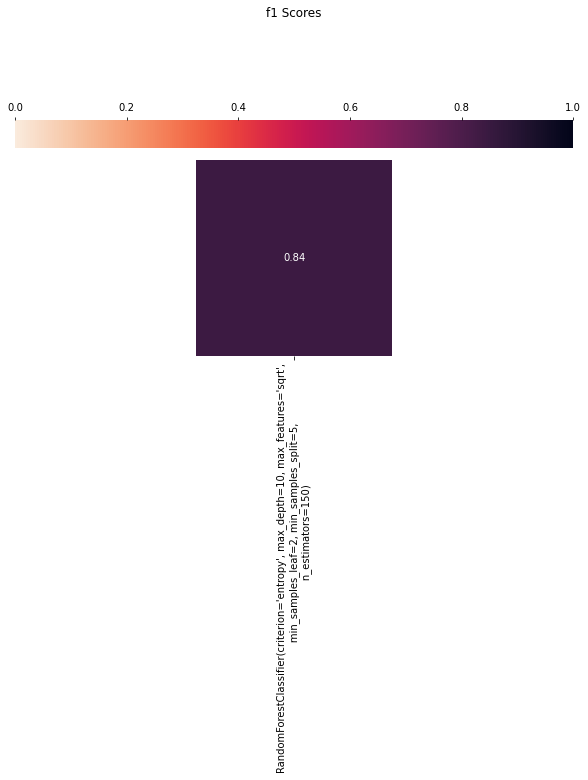

In [23]:
final_scores.show_score_table(show=True)

## b. KNN
Needs OneHotEncoding for y.

In [24]:
enc = OneHotEncoder()
enc.fit(y_train.values.reshape(-1, 1))
y_train_enc = enc.transform(y_train.values.reshape(-1, 1)).toarray()
y_test_enc = enc.transform(y_test.values.reshape(-1, 1)).toarray()

In [25]:
grid_parameters = {'n_neighbors': [1,2,5,10],
                   'weights': ('uniform', 'distance'),
                   'metric': ('minkowski', 'euclidean','chebyshev'),
                   'algorithm': ('auto', 'brute')} # 'ball_tree', 'kd_tree}

knn_forGrid = KNeighborsClassifier()
knn_gridsearch = GridSearchCV(knn_forGrid, grid_parameters, verbose=3, n_jobs=20, scoring="f1_weighted", refit="f1_weighted")
knn_gridsearch.fit(prepped_X_train, y_train_enc)

#Best Estimator:
knn_bestestimator = knn_gridsearch.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [26]:
knn_bestestimator.fit(prepped_X_train, y_train_enc)

knn_preds = knn_bestestimator.predict(prepped_X_test)
knn_f1 = f1_score(y_test_enc, knn_preds, average='micro')

final_scores.add_score_manually(knn_bestestimator, knn_f1)

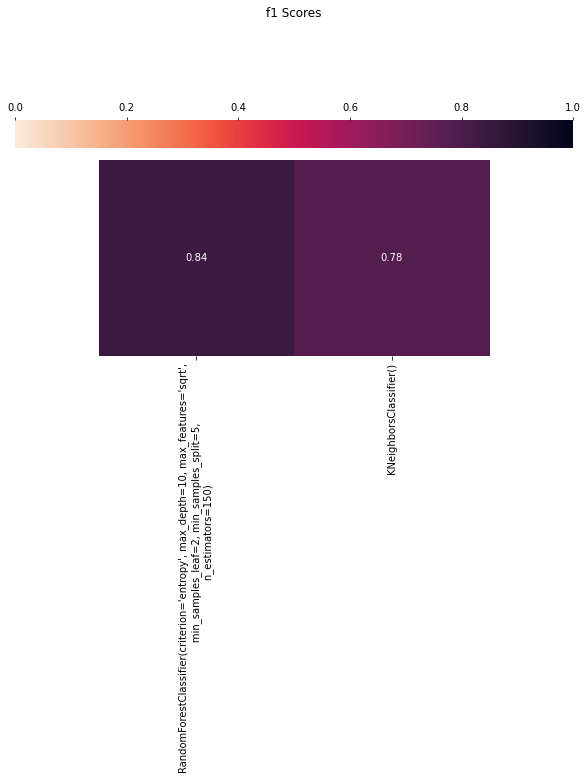

In [27]:
final_scores.show_score_table(show=True)

## c. SVM

In [28]:
grid_parameters = {'C':[1,2,10], 
                   'kernel':['linear', 'rbf', 'poly', 'sigmoid'],
                   'degree':[3,21],
                   'gamma':['auto'],
                   'tol':[0.001,0.1],
                   'cache_size':[200,500],
                   'decision_function_shape':['ovo']}


svc_forGrid = SVC()
svc_gridsearch = GridSearchCV(svc_forGrid, grid_parameters, verbose=3, n_jobs=20, scoring="f1_weighted", refit="f1_weighted")
svc_gridsearch.fit(prepped_X_train, y_train)

#Best Estimator:
svc_bestestimator = svc_gridsearch.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [29]:
svc_bestestimator.fit(prepped_X_train, y_train)
final_scores.add_score(str(svc_bestestimator), svc_bestestimator.predict(prepped_X_test))

0.7932960893854749

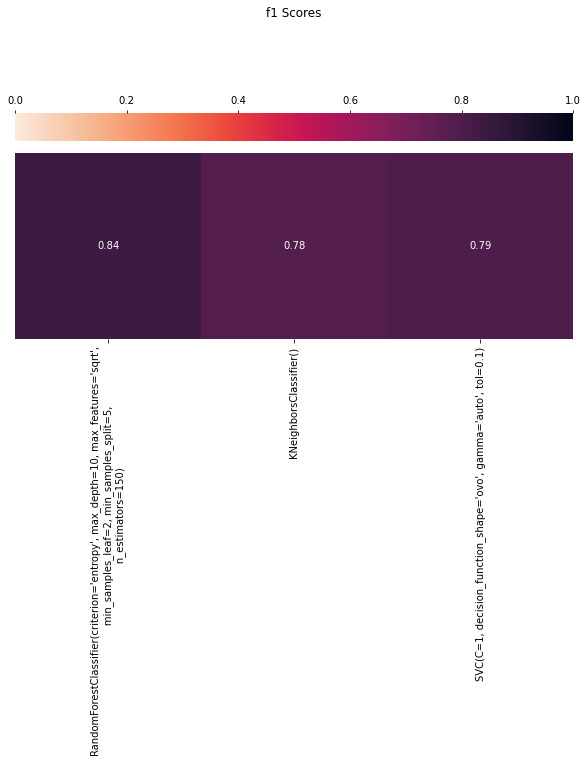

In [30]:
final_scores.show_score_table(show=True)

## d. MLPClassifier

In [31]:
grid_parameters = {'hidden_layer_sizes': [(5, 2)],
                   'max_iter': [5000],
                   'random_state': [1],
                   'activation': ['identity', 'logistic', 'tanh', 'relu'],
                   'solver': ['lbfgs', 'adam'],
                   'learning_rate': ['constant', 'adaptive']}
                                                               
mlp_forGrid = MLPClassifier()
mlp_gridsearch = GridSearchCV(mlp_forGrid, grid_parameters, verbose=3, n_jobs=20, scoring="f1_weighted", refit="f1_weighted")
mlp_gridsearch.fit(prepped_X_train, y_train)

#Best Estimator:
mlp_bestestimator = mlp_gridsearch.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [32]:
mlp_bestestimator.fit(prepped_X_train, y_train)
final_scores.add_score(str(mlp_bestestimator), mlp_bestestimator.predict(prepped_X_test))

0.8379888268156425

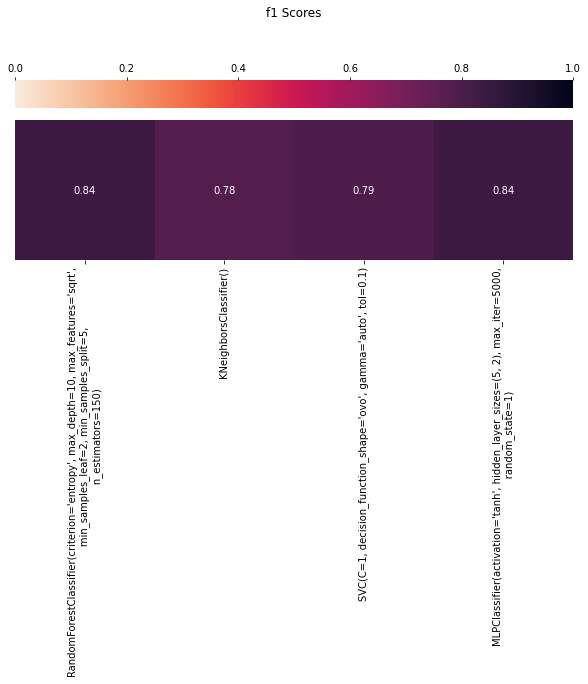

In [33]:
final_scores.show_score_table(show=True)

## e. Naive Bayes
Since there are no hyperparameter to tune, a GridSearch makes no sense.<br>

In [34]:
naive_bayes = GaussianNB()
naive_bayes.fit(prepped_X_train, y_train)

final_scores.add_score(str(naive_bayes), naive_bayes.predict(prepped_X_test))

0.7877094972067039

In [35]:
print("Chance to not survive:", round(naive_bayes.class_prior_[0],2))
print("Chance to survive:", round(naive_bayes.class_prior_[1],2))

Chance to not survive: 0.62
Chance to survive: 0.38


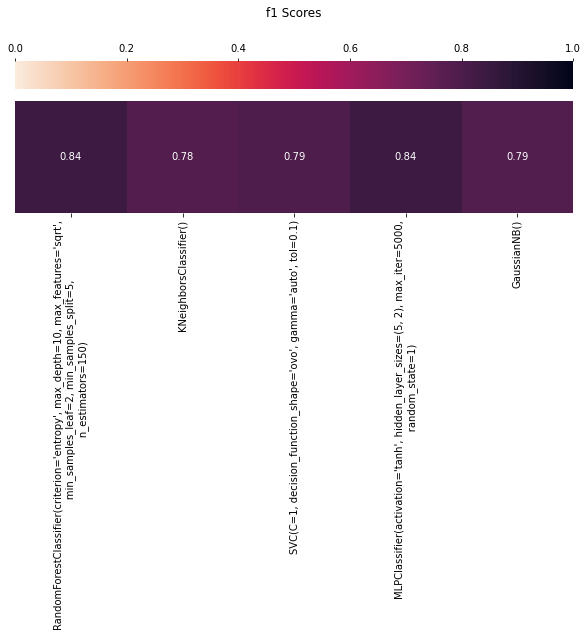

In [36]:
final_scores.show_score_table(show=True)

## f. Logistic Regression
GridSearch only works with 'l2' on this data.

In [37]:
grid_parameters = {'penalty':['l2'],
                   'tol':[0.001, 0.01, 0.1],
                   'C':[1,2,5,10], 
                   'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                   'max_iter': [100, 1000]}
                             
logr_forGrid = LogisticRegression()
logr_gridsearch = GridSearchCV(logr_forGrid, grid_parameters, verbose=3, n_jobs=20)
logr_gridsearch.fit(prepped_X_train, y_train)

#Best Estimator:
logr_bestestimator = logr_gridsearch.best_estimator_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


In [38]:
logr_bestestimator.fit(prepped_X_train, y_train)
final_scores.add_score(str(logr_bestestimator), logr_bestestimator.predict(prepped_X_test))

0.8212290502793297

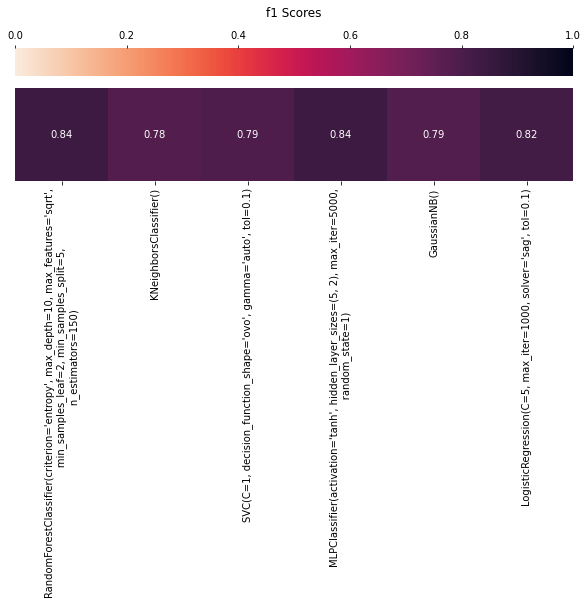

In [39]:
final_scores.show_score_table(show=True)

## g. Tensorflow Dense Net
Finding the best weights is performed via EarlyStopping on training train and validation data.

In [40]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(128, activation='tanh'))
model.add(tf.keras.layers.LayerNormalization ())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64, activation='tanh'))
model.add(tf.keras.layers.LayerNormalization ())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
                                
opt = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics='accuracy')

In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 patience=50,
                                                 restore_best_weights=True)

history = model.fit(prepped_X_train_train, y_train_train,
                    epochs=500, batch_size=32, 
                    validation_data=(prepped_X_train_val, y_train_val), 
                    verbose=2,
                    callbacks=[early_stopping])
model.summary()

Epoch 1/500
17/17 - 1s - loss: 0.7912 - accuracy: 0.5543 - val_loss: 0.6271 - val_accuracy: 0.6517
Epoch 2/500
17/17 - 0s - loss: 0.6558 - accuracy: 0.6704 - val_loss: 0.5925 - val_accuracy: 0.6742
Epoch 3/500
17/17 - 0s - loss: 0.6083 - accuracy: 0.6985 - val_loss: 0.5392 - val_accuracy: 0.7135
Epoch 4/500
17/17 - 0s - loss: 0.5965 - accuracy: 0.7154 - val_loss: 0.5223 - val_accuracy: 0.7247
Epoch 5/500
17/17 - 0s - loss: 0.5870 - accuracy: 0.7041 - val_loss: 0.5223 - val_accuracy: 0.7360
Epoch 6/500
17/17 - 0s - loss: 0.5712 - accuracy: 0.7228 - val_loss: 0.4999 - val_accuracy: 0.7528
Epoch 7/500
17/17 - 0s - loss: 0.5420 - accuracy: 0.7453 - val_loss: 0.4947 - val_accuracy: 0.7865
Epoch 8/500
17/17 - 0s - loss: 0.5324 - accuracy: 0.7472 - val_loss: 0.4839 - val_accuracy: 0.7865
Epoch 9/500
17/17 - 0s - loss: 0.5380 - accuracy: 0.7547 - val_loss: 0.4822 - val_accuracy: 0.7921
Epoch 10/500
17/17 - 0s - loss: 0.5113 - accuracy: 0.7697 - val_loss: 0.4730 - val_accuracy: 0.7921
Epoch 11/

Epoch 84/500
17/17 - 0s - loss: 0.4134 - accuracy: 0.8221 - val_loss: 0.4567 - val_accuracy: 0.8146
Epoch 85/500
17/17 - 0s - loss: 0.4330 - accuracy: 0.8146 - val_loss: 0.4601 - val_accuracy: 0.8146
Epoch 86/500
17/17 - 0s - loss: 0.4114 - accuracy: 0.8277 - val_loss: 0.4616 - val_accuracy: 0.8146
Epoch 87/500
17/17 - 0s - loss: 0.4182 - accuracy: 0.8146 - val_loss: 0.4636 - val_accuracy: 0.8090
Epoch 88/500
17/17 - 0s - loss: 0.4253 - accuracy: 0.8146 - val_loss: 0.4608 - val_accuracy: 0.8090
Epoch 89/500
17/17 - 0s - loss: 0.4194 - accuracy: 0.8202 - val_loss: 0.4606 - val_accuracy: 0.8146
Epoch 90/500
17/17 - 0s - loss: 0.4295 - accuracy: 0.8109 - val_loss: 0.4578 - val_accuracy: 0.8202
Epoch 91/500
17/17 - 0s - loss: 0.4398 - accuracy: 0.8127 - val_loss: 0.4587 - val_accuracy: 0.8202
Epoch 92/500
17/17 - 0s - loss: 0.4269 - accuracy: 0.8221 - val_loss: 0.4525 - val_accuracy: 0.8258
Epoch 93/500
17/17 - 0s - loss: 0.4437 - accuracy: 0.8127 - val_loss: 0.4601 - val_accuracy: 0.8202


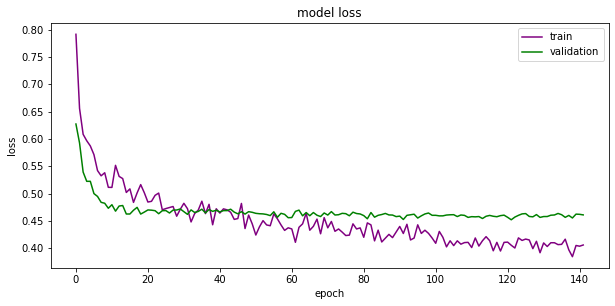

In [42]:
#Plotting loss during training:
plt.plot(history.history['loss'], label='training', color='purple')
plt.plot(history.history['val_loss'], label='validation', color='green')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

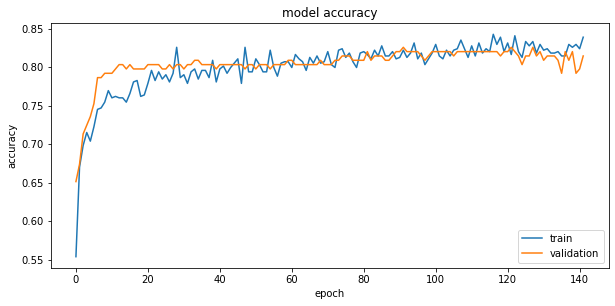

In [43]:
#Plotting accuracies during training:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.show()

In [44]:
model_preds = model.predict(prepped_X_test)
model_preds_rounded = [int(np.round(x)) for x in model_preds]
model_f1 = f1_score(y_test,model_preds_rounded, average='micro')
final_scores.add_score_manually("Tensorflow Dense Net", model_f1)

# Conclusion
As we can see, the best scores are delivered from the MLPClassifier and the RandomForest Algorithms.
To optimize the Dense Net Score, a GridSearch might help.

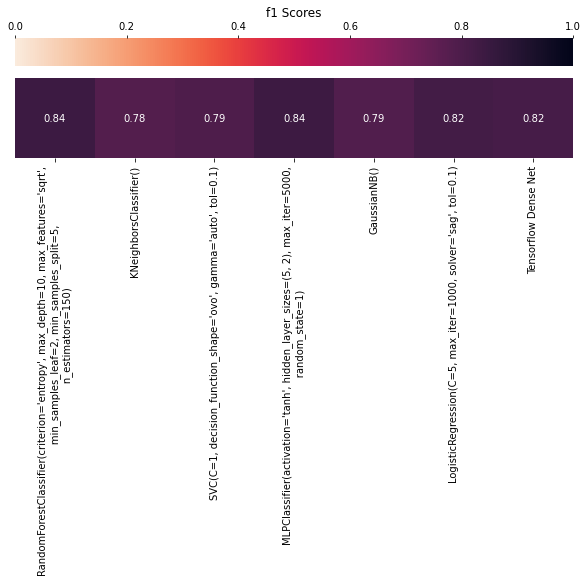

In [45]:
final_scores.show_score_table(show=True)